<a href="https://colab.research.google.com/github/emilny/ReloKmeans/blob/main/ReloK_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Initial package installment
Before imports can be made, some packages need to be installed.

Using `pip`, the following commands must be run in the terminal, or through the % magic command in a notebook environment:

```
pip install numpy
pip install scipy
pip install pandas
pip install matplotlib
pip install sklearn
pip install progressbar
pip install joblib
```




In [47]:
# All necessary packages and functions imports here
import random
import numpy as np
from scipy.spatial import distance_matrix
import pandas as pd
%matplotlib
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans
from google.colab import drive
import progressbar
from joblib import Parallel, delayed
import joblib
import math
import copy


Using matplotlib backend: nbAgg


# 1. Data
This snippet contains a function which reads data from `filename` and returns it in a pandas dataframe format. It also finds the file containing ground truth centroids, which is similarly returned as a dataframe (and a numpy array for certain special use cases) together with an inferred number of clusters `k`.

Be sure to change the path before running, as this will depend on data location.

In [48]:
#drive.mount('/content/gdrive/') # When using google drive to store data sets


def read_data_and_gt(filename):
  """
  Function to read from drive based on prefix of filename (i.e. "s1")
  :param filename: prefix of filename
  :return: Data in df, ground truth in df, and gt in ndarray, number of clusters k
  """
  # path = "/content/gdrive/My Drive/Maskinlæring/Prosjekt/datasets" # When using google drive to store data sets
  path = "/data" # If data sets are in the same folder as code

  if filename[:3] == "dim":
    dims = int(filename[3:])
    # Reads in higher dimensional data set and ground truth as pandas dataframe
    df = pd.read_csv(f"{path}/{filename}.txt", delim_whitespace="    ", names = [dim for dim in range(dims)])
    ground_truth_df = pd.read_csv(f"{path}/{filename}_gt.txt", delim_whitespace="    ",  names = [dim for dim in range(dims)])
  else:
    # Reads in 2D data set and ground truth as pandas dataframe
    df = pd.read_csv(f"{path}/{filename}.txt", delim_whitespace="    ", names = ['x', 'y'])
    ground_truth_df = pd.read_csv(f"{path}/{filename}_gt.txt", delim_whitespace="    ", names = ['x', 'y'])

  # Convert centroids to simple format [[point], [point],...]
  gt = ground_truth_df.values.tolist()

  k = len(gt) # Number of clusters in data set will depend on ground truth

  return df, ground_truth_df, gt, k


# 2. Support functions
The code blocks below contain functions that are used for intermediate calculations inside algorithms and during experiments, as well as for format conversions.

In [49]:
def distance(a, b, p):
    """
    Returns power distance between two points
    (p = 1 gives manhattan, p = 2 gives squared euclidian and so on)
    NOTE: This is not the same as minkowski distance, because the final number isn't raised to 1/p
    :param a: input point a
    :param b: input point b
    :param p: power to calculate distance in
    :return: distance between points raised to power p
    """
    diff = np.array(a) - np.array(b)
    diff = abs(diff)
    return sum(diff**p)

# Examples
print(distance([0,0], [2,2], 1))
print(distance([0,0], [2,2], 2))


4
8


In [50]:
def SSE(cluster_pts):
    """
    Calculates the Sum Squared Error (variance) within a cluster
    :param cluster_pts: list of points in a single cluster
    :return: float SSE
    """
    center = tuple(np.average(cluster_pts, axis=0))
    return sum(distance(center, point, 2) for point in cluster_pts)

# Examples
print(SSE([(1,1),(2,2),(3,3)]))
print(SSE([(1,1),(1,1),(1,1)]))

4.0
0.0


In [51]:
def score(clustering):
  """
  Finds score (total SSE) of an output clustering. That is, total SSE for all clusters in a partition
  :param clustering: dictionary with {index : List of list of points (i.e. list of clusters)}
  :return: float total SSE 
  """
  clusters = clustering.values()
  return sum(SSE(cluster_pts=cluster) for cluster in clusters)

# Example
print(score({0: [(1,1),(2,2),(3,3)],
             1: [(1,1),(1,1),(1,1)]}))

4.0


In [52]:
def CI(gt, centroids):
  """
  Function for comparing an output clustering (represented by centroid positions) to ground truth
  Centroid Index was introduced by:
  https://www.sciencedirect.com/science/article/pii/S0031320314001150#bib21

  Maps each centroid in gt to its closest neighbor in "centroids",
  Returns number of centroids in "centroids" that have no gt centroids mapped to it 
  (Such centroids are called orphans)
  
  :param gt: Ground truth centroids in ndarray
  :param centroids: Result centroids after running Kmeans or ReloKmeans
  :return: CI-value for a clustering
  """
  assert len(gt) == len(centroids)

  dist_matrix = distance_matrix(gt, centroids)**2 # Squared euclidian distances

  gt_to_centroids_mapping = [] # [2, 0,...] means gt[0]->centroids[2], gt[1]->centroids[0], ...
  for row in dist_matrix:
    gt_to_centroids_mapping.append(np.argmin(row))

  # Orphans are not mapped to by any gt centroid, want to return number of orphans
  orphans = set([i for i in range(len(centroids)-1)])-set(gt_to_centroids_mapping)
  
  return len(orphans)



In [53]:
def convert_to_dict(data, labels):
    """
    Function for converting KMeans output labels and data set into dictionary of labeled clusters
    Easier to work with, but computationally more exepensive. Could be optimized to decrease total run time.
    :param data: Data points in pandas dataframe format
    :param labels: labels for each point (row) in dataframe
    :return: Labeled clusters. Dict with key:values as label : List<points>
    """
    matrix = data.values.tolist()
    clustering = {}
    for i, label in enumerate(labels):
        if label in clustering.keys():
            clustering[label].append(tuple(matrix[i]))
        else:
            clustering[label] = [tuple(matrix[i])]
    return clustering

In [54]:
def convert_to_pd_series(centroids):
    """
    Function to convert data for 2D-plotting
    :param centroids: list of centroids
    :return: lists of x coordinates and y coordinates of centroids
    """
    centroids_x = pd.Series([point[0] for point in centroids])
    centroids_y = pd.Series([point[1] for point in centroids])
    return centroids_x, centroids_y


# 3. Components of the ReloKmeans algorithm
`reduce_centroids()` carries out the step of merging closest pair of centroids within the `relocate()` algorithm, i.e. "freeing up" centroids that can then be distributed elsewhere. The function is generalized to accomodate `n>1` as well, meaning relocating multiple centroids in a single step of ReloKmeans (discussed in Section 7 "Conclusion" for further work in project paper). 



In [55]:
def reduce_centroids(centroids, n):
    """
    Recursively reduces list of centroids by joining closest pair until new list of centroids contains n less than input
    :param centroids: Input centroid to be reduced
    :param n: number of centroids to remove
    :return: List of new centroids 
    """
    k = len(centroids)

    # Base case
    if n == 0:
        return centroids

    centroid_distances = distance_matrix(centroids, centroids)
    # Checking half of distance matrix excluding diagonal
    centroid_pairs = []
    for i in range(1, k):
        for j in range(0, i):
            centroid_pairs.append((i, j))
    sorted_pairs_by_dist = sorted(centroid_pairs, key=lambda pair: centroid_distances[pair[0], pair[1]])
    closest_pair = sorted_pairs_by_dist.pop(0)
    index1, index2 = closest_pair[0], closest_pair[1]
    c1, c2 = centroids[index1], centroids[index2]
    joined_centroid = tuple(np.average([c1, c2], axis=0))
    centroids.remove(c1)
    centroids.remove(c2)
    centroids.append(joined_centroid)
    return reduce_centroids(centroids, n-1)


`relocate()` is used for the relocation step that is carried out between calls to KMeans within ReloKmeans. This corresponds to Algorithm 1 which is described in Section 3.2 "Pseudocode" in the project paper.



In [56]:
def relocate(clusters, n=1):
    """
    Relocates centroids from dense areas to high-variance clusters.
    Step one: Finding n "worst" clusters, i.e. clusters with highest variance
    Step two: Finding n closest pairs of centroids (excluding worst), merging these into one, thus freeing up n centroids
    Step three: Placing two centroids instead of one in each of the n worst clusters, using a furthest point heuristic
    :param clusters: Dictionary containing numbered clusters (Output after running Kmeans on a data set)
    :param n: number of clusters to improve at once. Default is 1 because multiple at once might cause optimal solution 
    to be skipped
    :return: list of new centroid positions, i.e. input for another initialization of Kmeans.
    """
    k = len(clusters.keys())
    # Verify that n is not larger than k/2, as that would not make sense for this operation
    assert n < k / 2
    
    # Step one
    n_worst_clusters = sorted(clusters.values(), key=lambda cluster_pts: SSE(cluster_pts), reverse=True)[:n]
    n_worst_centroids = [tuple(np.average(cluster_pts, axis=0)) for cluster_pts in n_worst_clusters]

    # Step two
    remaining_clusters = sorted(clusters.values(), key=lambda cluster_pts: SSE(cluster_pts), reverse=True)[n:]
    remaining_centroids = [tuple(np.average(cluster, axis=0)) for cluster in remaining_clusters]
    new_centroids = reduce_centroids(remaining_centroids, n)

    # Verify that n centroids have been freed up by joining n close pairs (n worst are also currently missing at this point)
    assert len(new_centroids) == k-2*n  

    # Step three 
    # (ignores old centroid, places two new by first random selection and then point furthest away using manhattan dist)
    for cluster in n_worst_clusters:
        first_centroid = [random.choice(cluster)].copy()[0]
        furthest_away_centroid = sorted(cluster, key=lambda point: distance(point, first_centroid, 1))[-1]
        new_centroids.extend([first_centroid, furthest_away_centroid])
    
    # Verify that final number of centroids has not changed
    assert len(new_centroids) == k

    return new_centroids


# 4. The ReloKmeans algorithm
The code block below contains the function for running ReloKmeans on a data set. This algorithm is the nucleus of the project paper.

The implementation is generalized to accomodate `n>1` as well, meaning relocating multiple centroids between runs of `KMeans()`. To ensure that the best solution is returned when using `n>1`, the algorithm is re-run with `n=1` (skipping the initialization step) with the current best clustering once the call with `n>1` terminates. To understand why this has to be done, imagine the initial clustering having CI=9, i.e. 9 misplaced centroids. If `n=4`, three relocation steps would most likely be executed, the last step "overshooting" by 3 (CI would most likely take on values 9, 5, 1, 3), and the returned result would have a CI value of 1. Instead, the algorithm re-runs on the returned clustering with `n=1`, likely performing two relocation steps (CI taking on values 1, 0, 1) before returning the result with CI=0. 

In [57]:
def ReloKmeans(data, k=15, n=1, random_initial=True, rec_params=None):
    """
    Repeats Kmeans while relocating potentially misplaced centroids between every repeat.
    Repeats continue until result stops improving, i.e. when score(clustering) increases.
    When score of a clustering increases compared to last, the previous clustering is returned
    
    Uses Sklearn's KMeans to perform clustering in each run.

    :param rec_params: Parameters passed in case n>1 and a recursive call is made with n=1.
                        format will be (result_clustering, scores, plotting_list)
    :param random_initial: Whether to use random or Kmeans++ initialization for first run
    :param data: input data points in pandas dataframe format
    :param k: number of clusters
    :param n: number of centroids to relocate at a time. Default is 1 to avoid "skipping over" best solution
              If n>1 recursive call is made with n=1 to ensure best solution is found
    :return: clustering solution;
              plotting_list (list of the different configurations of centroids that have occurred throughout the algorithm);
              scores (list of the different scores that have been acheived throughout the algorithm, for plotting purposes)
              run_times (containing run times of each call to KMeans, for plotting purposes)
    """
    run_times = [] # Recording run times for each call to KMeans()
    # Checking if we are in recursive call or not
    if rec_params is None:
        
        start = time.time()
        
        km = KMeans(n_clusters=k,
                    init="random" if random_initial else "k-means++",
                    n_init=1,  # Don't want to run Kmeans multiple times with our algorithm (default is 10 repeats)
                    ).fit(data.to_numpy())
        run_times.append(time.time()-start)

        # Output of initial run is scored
        current_clustering = convert_to_dict(data, km.labels_)
        current_score = score(current_clustering)

        # Keeping track of centroids produced for plotting purposes
        plotting_list = []
        current_centroids = km.cluster_centers_
        plotting_list.append(current_centroids)

        # Keeping track of scores (SSE) for different runs
        scores = [current_score]
    else:
        current_clustering = rec_params[0]
        scores = rec_params[1]
        plotting_list = rec_params[2]
        run_times = rec_params[3]
        current_score = min(scores) # Best score reached from previous call

    # Try to improve by relocating n centroids
    new_centroids = relocate(current_clustering, n=n)

    start = time.time()
    # Run K-means again with new initial centroids (improved centroids from previous run)
    new_km = KMeans(n_clusters=k,
                    init=np.array(new_centroids),
                    n_init=1,
                    # Don't want to run Kmeans multiple times with our algorithm (default is 10 repeats)
                    ).fit(data.to_numpy())
    run_times.append(time.time()-start)
    
    # Output of new run is scored
    new_clustering = convert_to_dict(data, new_km.labels_)
    new_score = score(new_clustering)

    # Score is saved
    scores.append(new_score)

    while new_score < current_score:  # Continue improving centroids until score stops decreasing

        # Record new centroids for plotting (Don't want to plot last centroids, since these will be worse
        result_centroids = new_km.cluster_centers_
        plotting_list.append(result_centroids)

        # Move "current" to new, since new_score was better
        current_score = new_score
        current_clustering = new_clustering

        # Try to improve by relocating n centroids
        new_centroids = relocate(current_clustering, n=n)

        start = time.time()
        # Run K-means again with new initial centroids
        new_km = KMeans(n_clusters=k,
                        init=np.array(new_centroids),
                        n_init=1 # Don't want to run Kmeans multiple times with our algorithm (default is 10 repeats)
                        ).fit(data.to_numpy())
        run_times.append(time.time()-start)

        # Output of new run is scored
        new_clustering = convert_to_dict(data, new_km.labels_)
        new_score = score(new_clustering)

        # Score is saved
        scores.append(new_score)

    # If n was >1 then we need to check result with n=1 to make sure optimal solution was not overshot
    if n > 1:
        rec_params = (current_clustering, scores, plotting_list)
        return ReloKmeans(data, k=k, n=1, max_iter=max_iter, rec_params=rec_params)

    return current_clustering, plotting_list, scores, run_times

# 5. Experiments
Code blocks below are used for performing trials and experiments on the algorithms. 

As described in Section 5 "Experiments" in the project paper, Repeated Kmeans is tested somewhat differently compared to ReloKmeans.
`repeat_until_correct()` measures the required attempts to acheive CI=0 for Repeated Kmeans, and returns the lowest CI-value in trials where CI=0 isn't acheived before `attempts=cutoff`.

ReloKmeans is simply called once on the data set in a single trial, and carries out calls to `KMeans()` on its own until termination. The number of attempts is then easily inferred from the number of scores recorded within ReloKmeans. CI-value is then recorded for that trial by checking the returned clustering.


In [58]:
def repeat_until_correct(data, gt, cutoff, random_initial, k):
  """
  Function for repeating KMeans until a result is correct (CI=0). 
  USED FOR RUNNING A SINGLE TRIAL WITHIN multiple_trials()
  If CI=0 is not reached after cutoff repeats the function returns attempts = cutoff 
  and lowest CI-value acheived before cutoff
  :params: See multiple_trials() description
  :return: (attempts, min_ci(=0)) or (attempts(=cutoff), min_ci)
  """
  km = KMeans(n_clusters=k,
              init="random" if random_initial else "k-means++",
              n_init=1,  # Don't want to run Kmeans multiple times with our algorithm (default is 10 repeats)
              ).fit(data.to_numpy())
  result = km.cluster_centers_
  ci = CI(gt, result)
  min_ci = ci # Keeping track of lowest ci acheived in case no success until cutoff
  attempts = 1
  while attempts < cutoff and ci!=0:
    km = KMeans(n_clusters=k,
              init="random" if random_initial else "k-means++",
              n_init=1,  # Don't want to run Kmeans multiple times with our algorithm (default is 10 repeats)
              ).fit(data.to_numpy())
    result = km.cluster_centers_
    ci = CI(gt, result)
    min_ci = min((min_ci, ci))
    attempts += 1
  return attempts, min_ci

def mulitple_trials(n_trials, data, gt, k, n, relokm=True, random_initial=True, cutoff=10):
  """
  Function for running ReloKmeans(&++) or KMeans(&++) multiple times and recording number of calls to
  Kmeans until convergence for each execution, as well as CI index when termination does not occur before cutoff
  :param n_trials: number of trials to record
  :param data: pandas dataframe containing data points to be clustered
  :param gt: ground truth centroids for data set (as ndarray)
  :param k: number of clusters
  :param n: number of centroids to relocate at a time, default is 1
  :param relokm: Boolean value deciding which of the clustering algorithms to use
  :param random_initial: Boolean value deciding whether to use naive or k++ initialization
  :param cutoff: Number of attempts to allow for in each trial of Repeated KMeans
  :return: list of CI values acheived, list of number of calls to KMeans. 
  Results from first trial correspond to first value in CI_values and first number in number_of_calls (and so on)
  """
  number_of_calls = []
  CI_values = []

  # Progress bar for monitoring process 
  bar = progressbar.ProgressBar(maxval=n_trials, \
      widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
  bar.start()
  
  if relokm:
    for i in range(n_trials): 
      clustering, plotting_list, scores, run_times = ReloKmeans(data, random_initial=random_initial, k=k, n=n)
      result = plotting_list[-1]
      ci = CI(gt, result)
      number_of_calls.append(len(scores)) # Records scores after every call, so just count those
      CI_values.append(ci)
      bar.update(i+1)
      #if ci >0:
      #  gt_df = pd.DataFrame(np.array(gt), columns=["x","y"])
      #  plot_centroids([plotting_list[0], plotting_list[-1]], gt_df=gt_df)
  else:
    for i in range(n_trials): 
      attempts, min_ci = repeat_until_correct(data, gt, cutoff, random_initial, k)
      number_of_calls.append(attempts)
      CI_values.append(min_ci) # Whenever min_ci is not 0 we know cutoff happened
      bar.update(i+1)

  bar.finish()
  return CI_values, number_of_calls


Multiprocessing was used to carry out tasks that could be performed independently - this saves a substantial amount of time when multiple CPUs are available. 

In [59]:
def collect_tasks_for_each_algo(filename, n_trials = 1000, cutoff=100):
  """
  Collects tasks for processes to run n_trials on data set and record results for all 4 algorithms
  :param filename: name of data set, e.g. "s1"
  :param n_trials: Number of trials to complete for each algo
  :return: 4 tasks, one for each algo (delayed, using joblib)
  """
  
  df, ground_truth_df, gt, k = read_data_and_gt(filename)

  # Arguments to pass into multiple_trials() to vary algo
  algo_settings = {"NKM": (False, True),
                  "ReloKM": (True, True),
                  "KM++": (False, False),
                  "ReloKM++": (True, False)
                  }

  # Collect 4 tasks: running n_trials on each algo
  tasks = [delayed(mulitple_trials)(n_trials, df, gt, k, 1,algo_settings[alg][0], algo_settings[alg][1], cutoff) for alg in algo_settings.keys()]

  return tasks

Code below runs trials by performing the collected tasks for each data set
Number of tasks is then 4*(number of data sets), which can be done concurrently.
When running, each process bar corresponds to a single algo performing `n_trials` on a single data set

To perform trials: Provide list of data set names in `setnames` argument, and enter desired `n_trials` and `cutoff` into function call at the bottom.

In [60]:
def run_trials_on_all_data_sets(setnames, n_trials=1000, cutoff=100):
  """
  Runs trials on a list of data sets
  Runs on multiple processes if several CPUs are available
  :param setnames: names of data sets
  :param n_trials: Number of trials to perform for each algo on each data set
  :param cutoff: See description in multuple_trials()
  :return: Dictionary containing key:value as setname : algo_results, where 
  algo_results is again a dictionary with key:value as algo : result
  """
  algo_names = ["NKM","ReloKM", "KM++", "ReloKM++"]
  data_set_results = {}

  executor = Parallel(n_jobs=-1, backend= 'multiprocessing')
  tasks = []
  for setname in setnames:
    tasks.extend(collect_tasks_for_each_algo(setname, n_trials, cutoff))
  results = executor(tasks)
  algo_results = {} # Temporarily holds results for each algo on a single data set

  for i, algo_result in enumerate(results):
    #Fill up result dict for set floor(i/4)
    algo = algo_names[i%4]
    algo_results[algo] = algo_result

    if (i+1)%4 == 0: # Next idx will be for next set, so copy dict and add to results
      setname = setnames[math.floor(i/4)]
      data_set_results[setname] = copy.deepcopy(algo_results)
  return data_set_results


# DEFINE DATA SETS HERE
# setnames = ["s1","s2","s3","s4"]
setnames = ["a1","a2", "a3"]
#setnames = ["dim256"]
#setnames = ["b2_k15","b2_k25","b2_k50","b2_k75", "b2_k100"]

# ENTER DESIRED NUMBER OF TRIALS AND CUTOFF HERE
# n_trials=10 for simplicity, increase this for more reliable results
data_set_results = run_trials_on_all_data_sets(setnames, n_trials = 10, cutoff = 10)


[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


The code below calculates averages and relevant information from trial results, and prints them nicely. 

In [61]:
def print_results(data_set_results):
  """
  Function for printing results from trials of algorithms on data sets
  :param data_set_results: Dictionary containing setname -> algo_results pairs
  :return:
  """
  for setname, algo_results in data_set_results.items():
    #Prints out trial results nicely for every algo in algo results
    print("="*100)
    print(f"{setname.upper()} Data Set".rjust(27))
    print("="*100)

    for algo in algo_results.keys():
      print("="*100)
      print(f"#################   {algo}    ######################################")
      ci_vals, ncalls = algo_results[algo] # Idx 0 means first trial, so ci_vals[0] is min ci acheived and ncalls[0] is number of calls made during first trial 

      success_ncalls = [] # All trials where ci_val=0
      failed_ci_vals = [] # All trials where ci_val>0
      failed_ncalls = [] # Number of calls before fail (will be equal to cutoff+1 for RKM)
      for i, ci_val in enumerate(ci_vals):
        if ci_val==0:
          success_ncalls.append(ncalls[i])
        else:
          failed_ci_vals.append(ci_val)
          failed_ncalls.append(ncalls[i])

      n_success = len(success_ncalls)
      n_fails = len(failed_ci_vals)

      avg_success_ncalls = None if n_success == 0 else np.mean(success_ncalls)      # What is the average number of calls required to reach CI=0?
      avg_fail_ci_val = None if n_fails == 0 else np.mean(failed_ci_vals)           # When it fails, what is the average CI value it acheives?
      avg_fail_ncalls = None if n_fails == 0 else np.mean(failed_ncalls)            # When it fails, how many calls does it make on average?

      print("Number of successes".ljust(35), f": {n_success}")
      print("Number of fails".ljust(35), f": {n_fails}")
      print("Average repetitions to reach CI=0".ljust(35), f": {avg_success_ncalls}")
      print("Average achieved CI at failure".ljust(35), f": {avg_fail_ci_val}")
      print("Average number of calls at failure".ljust(35), f": {avg_fail_ncalls}")
  

print_results(data_set_results)

                A1 Data Set
#################   NKM    ######################################
Number of successes                 : 1
Number of fails                     : 9
Average repetitions to reach CI=0   : 7.0
Average achieved CI at failure      : 1.0
Average number of calls at failure  : 10.0
#################   ReloKM    ######################################
Number of successes                 : 10
Number of fails                     : 0
Average repetitions to reach CI=0   : 4.7
Average achieved CI at failure      : None
Average number of calls at failure  : None
#################   KM++    ######################################
Number of successes                 : 10
Number of fails                     : 0
Average repetitions to reach CI=0   : 1.8
Average achieved CI at failure      : None
Average number of calls at failure  : None
#################   ReloKM++    ######################################
Number of successes                 : 10
Number of fails                  

# 6. Run time analysis
Code below is used for experiments described in Section 5.2 "Setup and Implementation", and further discussed in Section 6.4 "Run times within ReloKmeans" in the project paper.

Can be performed on different data sets by entering desired setname in function call at the bottom. `n_runs` defines how many runs to perform on the set. In the project paper, an average from `n_runs=1000` was deemed sufficient to illustrate a representative performance.

[========================================================================] 100%


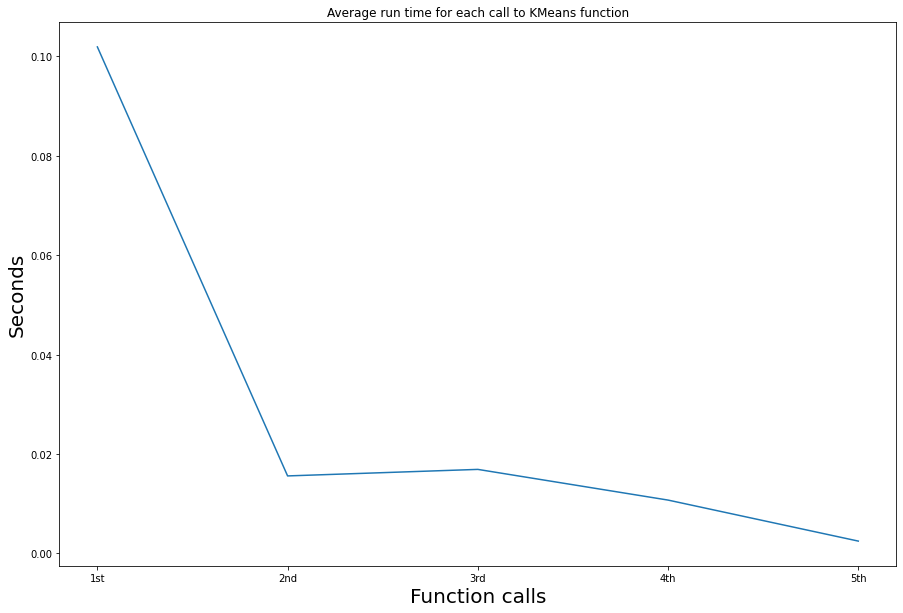

In [62]:
def find_avg_run_times(n_runs, setname):
  """
  Function to run ReloKMeans a number of times and record average run time for each call to sklearn.KMeans() within the process

  :param n_runs: number of runs to perform
  :param setname: name of data set to perform trials on
  :return: A list of average run times for 1st, 2nd, 3rd (and so on) calls to sklearn clustering function 
  """
  df, ground_truth_df, gt, k = read_data_and_gt(setname)

  total = []
  bar = progressbar.ProgressBar(maxval=n_runs, \
      widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
  bar.start()
  for i in range(n_runs):
    _, __, ___, run_times =  ReloKmeans(df,random_initial=False, k=k, n=1)
    # Excluding last run time (which takes slightly longer) but we ignore this
    # to illustrate the effect of closing in on global optimum
    for j, runtime in enumerate(run_times): 
      bar.update(i+1)
      if j>len(total)-1:
        total.append(runtime)
      else:
        total[j] += runtime
  bar.finish()
  avg = np.array(total)/n_runs
  return avg

def plot_avg_run_times(avg):
  """
  Function for plotting average run times
  :param avg: List of average run times from function find_avg_run_times()
  """
  plt.figure(figsize=[15,10])
  plt.title("Average run time for each call to KMeans function")
  plt.rc('xtick', labelsize=20)
  plt.rc('ytick', labelsize=20)
  plt.xticks([i+1 for i in range(len(avg))], ('1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th','17th','18th', '19th', '20th'))
  plt.ylabel("Seconds", fontsize=20)
  plt.xlabel("Function calls", fontsize=20)
  plt.plot([i+1 for i in range(len(avg))], avg)


# ENTER DESIRED SETNAME AND NUMBER OF RUNS HERE
avg = find_avg_run_times(n_runs=10, setname="a3") # n_runs=10 for simplicity, increase this for more reliable results
plot_avg_run_times(avg)

# 7. Visualizing a run of ReloKmeans
The code block below runs ReloKmeans on a desired data set and subsequently plots relevant information about the run and the clustering process. 

Time and scores are presented immediately below.

The last code block presents a scatterplot of the data together with three centroid configurations. 
- Black X's represent centroid placements from initial clustering performed inside ReloKmeans
- Magenta o's represent centroid placements after ReloKmeans has terminated, 
- Golden stars represent the ground truth.

Total time spent               : 0.446 seconds
First score achieved           : 20528927631712.38
Lowest score achieved          : 8917650006651.11
Score of returned solution     : 8917650006651.11


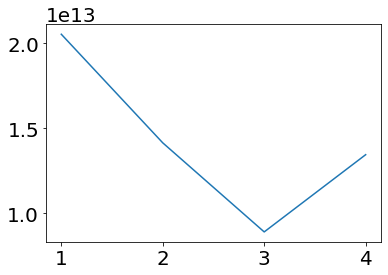

In [63]:
#ENTER DESIRED VALUES BELOW

random_initialization = True # True: uses Naïve Kmeans on initial clustering (ReloKmeans)
                             # False: uses KMeans++ on initial clustering    (ReloKmeans++)

n=1                          # Relocates n centroids at a time, default is 1.
data_set_name = "s1"         # Which data set to perform clustering on


start = time.time()
df, ground_truth_df, gt, k = read_data_and_gt(data_set_name)
result_clustering, plotting_list, scores, run_times = ReloKmeans(df,random_initial=random_initialization, k=k, n=n)
tot_time = time.time()-start

#plt.plot([i+1 for i in range(len(run_times))], run_times) #Plots run times of KMeans within this run of ReloKmeans

plt.plot([i+1 for i in range(len(scores))], scores) # Plots scores of each clustering result produced within this run of ReloKmeans

print("Total time spent".ljust(30), ": {0:.3f} seconds".format(tot_time))
print("First score achieved".ljust(30), ": {}".format(scores[0]))
print("Lowest score achieved".ljust(30), ": {}".format(min(scores)))
print("Score of returned solution". ljust(30), ": {}".format(score(result_clustering)))

In [64]:
# Code for visualizing the different centroid configurations on top of the data.

def plot_centroids(plotting_list, gt_df=None):
    """
    Function for plotting centroids and ground thruth (if given)
    :param plotting_list: Sets of centroids from different runs to be plotted 
    :param gt_df: (Optional) Ground thruth centroids from data set source
    :return:
    """
    num_centroids = len(plotting_list)

    figure = plt.figure(figsize=[15,15])
    
    # Plot data points
    plt.scatter(df['x'], df['y'], s=10)

    # Plot ground truth if available
    if gt_df is not None:
        plt.scatter(gt_df["x"], gt_df["y"], marker="*", c="gold", s=600, linewidths=1, edgecolors="black")

    # Plot centroids in plotting list (normally only two sets of centroids)
    for i, centroids in enumerate(plotting_list):
        marker, color, size, alpha = ("o", "magenta", 50, 1) if i == num_centroids-1 else ("X", "black", 250, 1)

        cent_x, cent_y = convert_to_pd_series(centroids)
        plt.scatter(cent_x, cent_y, marker=marker, c=color, s=size, alpha=alpha)



Returned solution:
Centroid Index: 0

First solution:
Centroid Index: 2


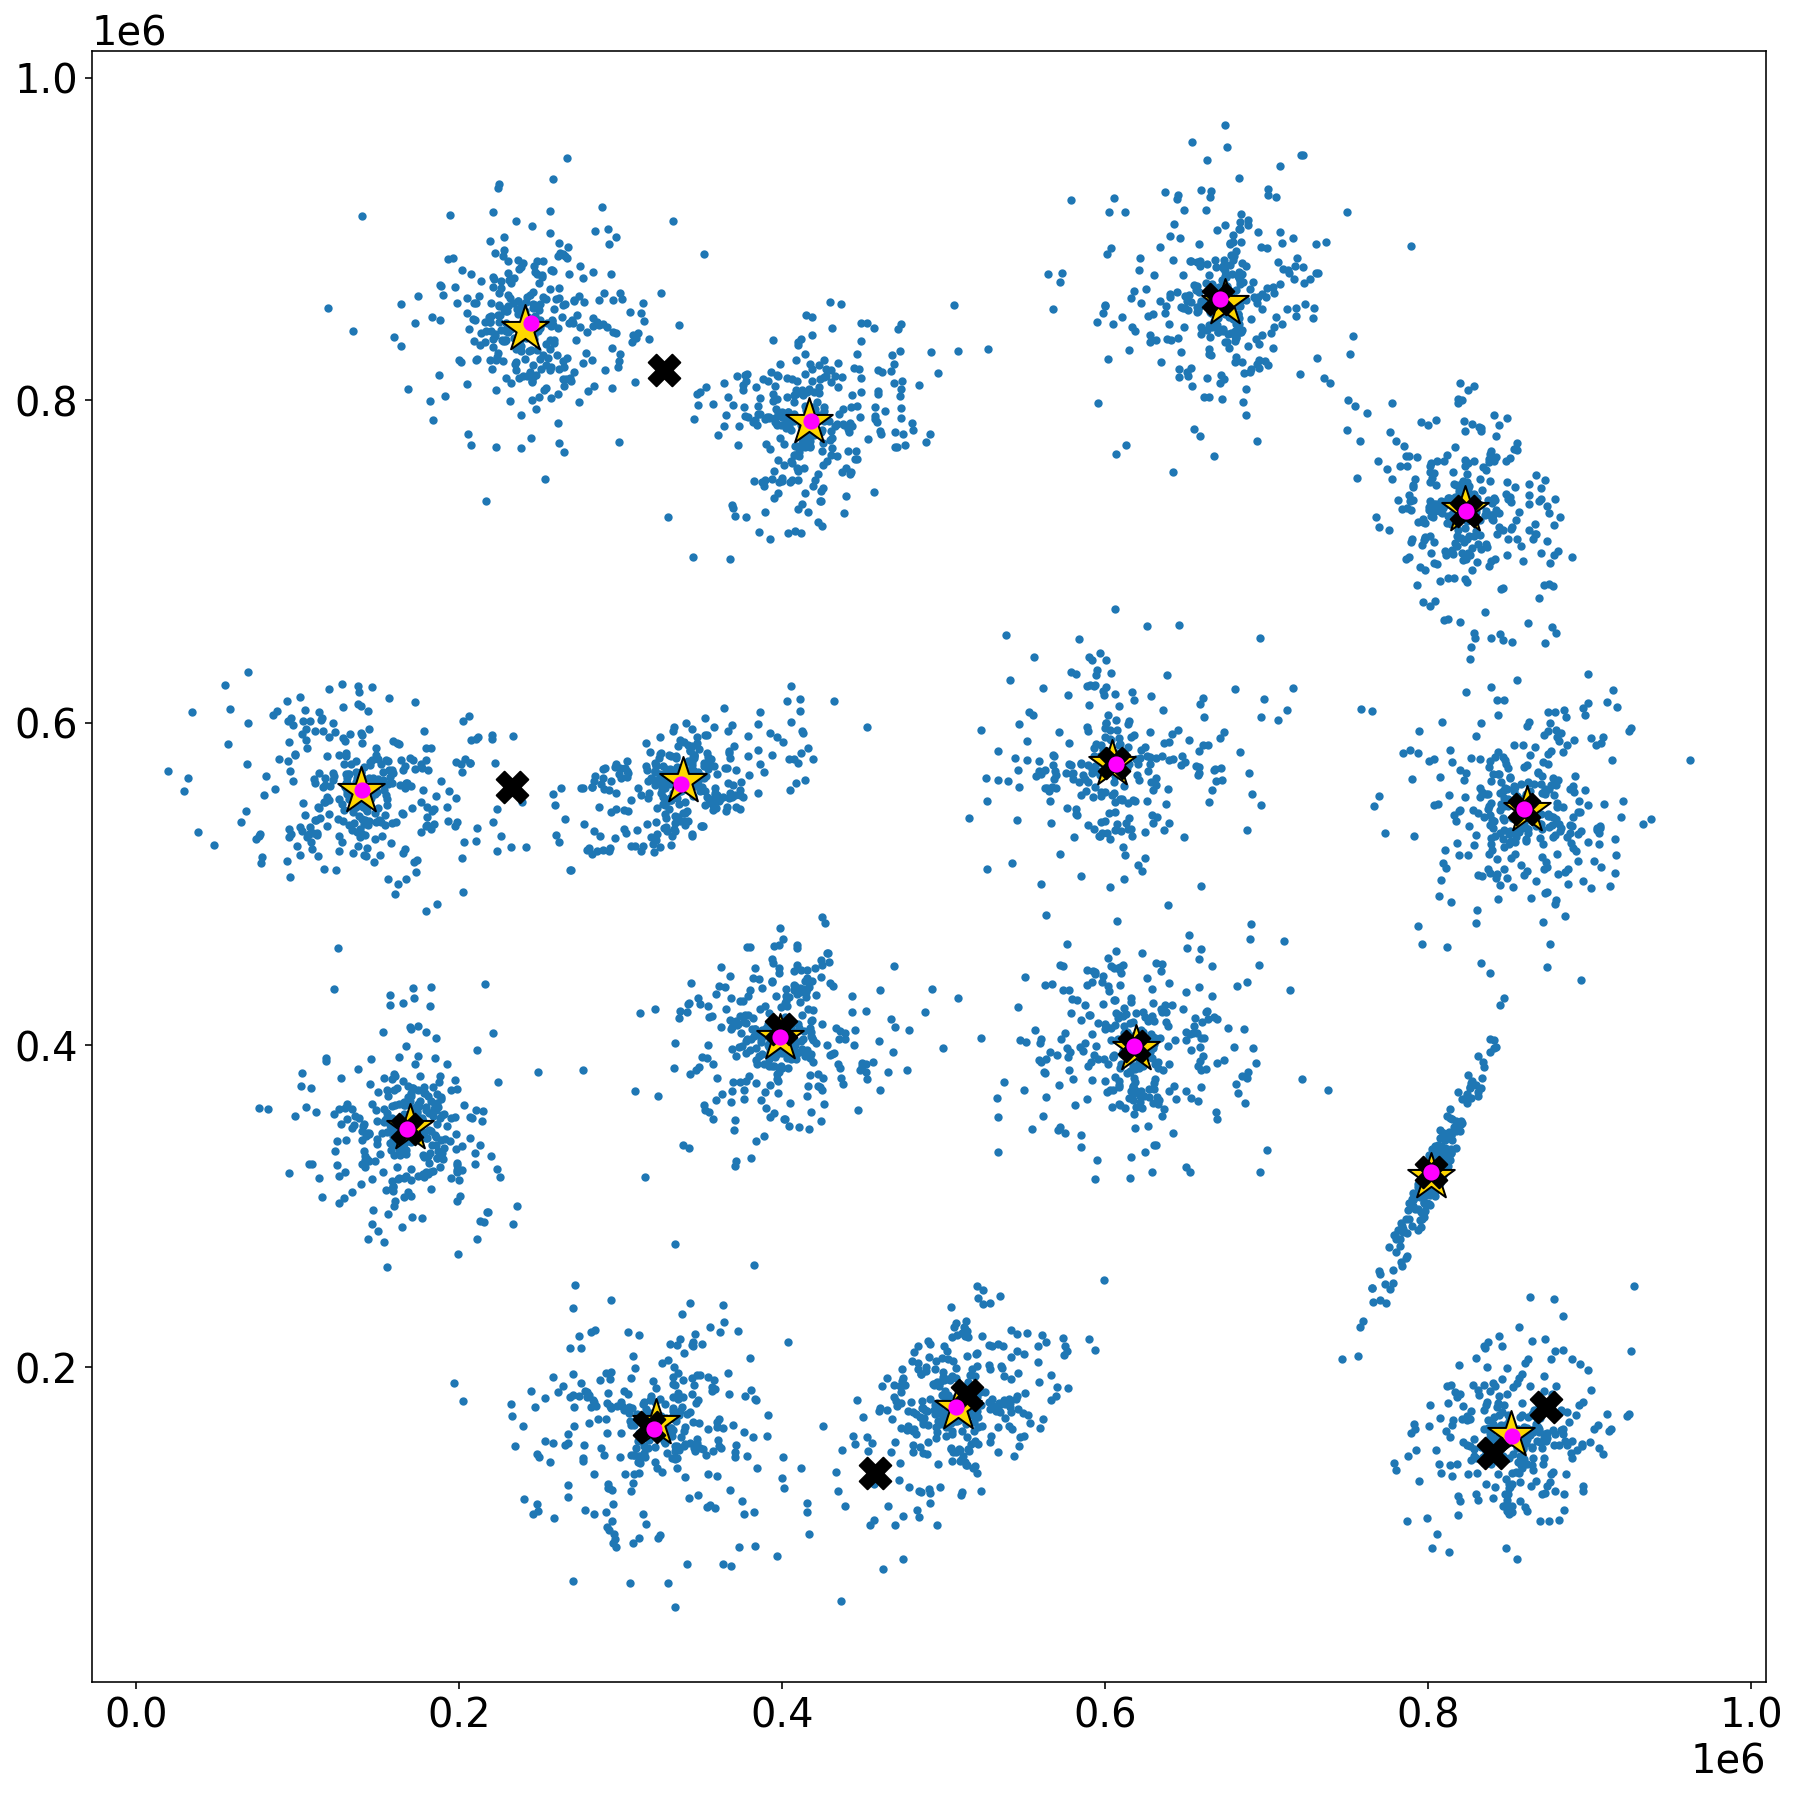

In [65]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
result = plotting_list[-1] # Last item represents centroids in returned solution (Centroids from termination clustering, i.e. when score increases, are not included in plotting list)
initial = plotting_list[0] # First clustering performed by KMeans inside ReloKmeans

print("Returned solution:")
print("Centroid Index:", CI(gt, result))
print()
print("First solution:")
print("Centroid Index:", CI(gt, plotting_list[0]))

plot_centroids([initial, result], gt_df=ground_truth_df)